In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import os
import matplotlib.pyplot as plt

print(tf.__version__)

0.11.0


In [2]:
df = pd.read_csv("../features/features_global.csv", sep=',', header=None, low_memory=False, na_values=['null'])

### Just a tiny bit of wrangling

In [3]:
df.isnull().sum().sum()

1309

In [4]:
df.ix[:,0].value_counts()


blue      7037
purple    6696
Name: 0, dtype: int64

In [3]:
df = df.dropna()

In [6]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,162,163,164,165,166,167,168,169,170,171
0,blue,2984814498,0.650000,423.95993,1.917431,0.917431,2.900000,133402.100,17926.000,16480.800,...,13711.350,114.10000,1.190000,1.685000,-0.402500,-0.352500,193.48500,332.70502,-10.030000,-7.407500
1,purple,3034035764,0.526316,402.25280,2.000000,1.000000,2.157895,137797.310,17697.053,17959.790,...,17441.264,302.21054,1.189474,1.642105,0.100000,-0.081579,200.77895,350.03687,4.418421,30.384210
2,purple,3036731710,0.409091,421.79210,2.215569,1.215569,3.636364,154794.270,23505.592,24949.682,...,29733.684,782.63160,0.326316,0.773684,-0.036842,-0.413158,223.42105,339.43683,-9.331579,-31.594736
3,purple,3018436026,0.473684,384.25073,1.917526,0.917526,2.368421,136257.270,17298.736,18882.053,...,14255.750,136.25000,0.235000,0.405000,-0.330000,-0.022500,165.56500,310.27000,0.042500,65.232500
4,blue,3026930091,0.478261,398.31564,2.887755,1.887755,4.173913,125274.305,17986.130,22280.957,...,16022.895,226.68420,7.163158,6.894737,0.857895,0.323684,288.94210,461.35263,24.378946,56.265793


In [7]:
df.shape

(13660, 172)

## Neural Net with tensorflow:

In [4]:
#Global constants
seed = 7875
validation_size = 750
feature_count = df.shape[1] - 2

#feed forward neural net
n_nodes_hl1 = 110
n_nodes_hl2 = 0
n_nodes_hl3 = 0

#cycles of feed forward + backprop on all K-folded samples
hm_epochs = 85

n_classes = 2

model_path = "./finalmodel/model.ckpt"
save_dir = './finalmodel/'

x = tf.placeholder('float', [None, feature_count], name = 'xa')
y = tf.placeholder('float', [None, n_classes], name='ya')
dropout_prob = tf.placeholder('float', (), name = 'dropout_prob')


In [5]:
import pickle

X = np.asarray(df.ix[:,2:feature_count+2])
#standardize X
meanX = np.mean(X, axis = 0)
stdX = np.std(X, axis = 0)

# We save the mean and the variance from the data since we need it later when we make predictions
f = open('mean.pckl', 'wb')
pickle.dump(meanX, f)
f.close()

f = open('std.pckl', 'wb')
pickle.dump(stdX, f)
f.close()

X = (X - meanX) / stdX

Y_1 = np.asarray(df.ix[:,0])
Y_1 = [int(y == "purple") for y in Y_1]
#one hot Y
Y = np.zeros(shape=(len(Y_1), n_classes))
Y[np.arange(len(Y_1)), Y_1] = 1
    
validation_features = X[:validation_size]
validation_labels = Y[:validation_size]

train_features = X[validation_size:]
train_labels = Y[validation_size:]

num_examples = train_features.shape[0]

In [6]:
def display_stat(x_range, trains, tests, vals, acc_0s, acc_1s):
    
    #plt.plot(x_range, trains,'-b', label='Training acc')
    #plt.plot(x_rang±ange, tests,'-y', label='Test acc')
    plt.plot(x_range, acc_0s,'-r', label='Acc Class 0')
    plt.plot(x_range, acc_1s,'-k', label='Acc Class 1')

    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.0)

    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()
    
    plt.plot(x_range, trains,'-b', label='Training acc')
    plt.plot(x_range, tests,'-y', label='Test acc')

    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.0)

    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()
    

In [7]:
def train_neural_network_CV(x, lambda_):

    hidden_1_layer = {
        'weights': tf.Variable(tf.truncated_normal([feature_count, n_nodes_hl1], stddev=0.1, seed=seed), name="h1_weights"),
        # 'weights': tf.Variable(tf.zeros([feature_count, n_nodes_hl1]), name="h1_weights"),
        'biases': tf.Variable(tf.constant(1.0, shape=[n_nodes_hl1]), name="h1_biases")
    }
    
    output_layer = {
        'weights': tf.Variable(tf.truncated_normal([n_nodes_hl1, n_classes], stddev=0.1, seed=seed), name="o_weights"),
        # 'weights': tf.Variable(tf.zeros([n_nodes_hl1, n_classes]), name="o_weights"),
        'biases': tf.Variable(tf.constant(1.0, shape=[n_classes]), name="o_biases")
    }

    l1 = tf.add(tf.matmul(x, hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.relu6(l1)

    l1_drop = tf.nn.dropout(l1, dropout_prob, seed=seed)

    to_save = [hidden_1_layer['weights'], hidden_1_layer['biases'], output_layer['weights'], output_layer['biases']]

    prediction = tf.matmul(l1_drop, output_layer['weights']) +  output_layer['biases']

    regularizers = (tf.nn.l2_loss(hidden_1_layer['weights']) + tf.nn.l2_loss(hidden_1_layer['biases']) +
                                tf.nn.l2_loss(output_layer['weights']) + tf.nn.l2_loss(output_layer['biases']))

    #stats 
    vals = []
    trains = []
    tests = []
    x_range = []
    f1_vals = []
    acc_1s = []
    acc_0s = []

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(prediction, y))

    #Eval this to get probability of [winning,losing]
    prob = tf.nn.softmax(prediction, name="prob")

    optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost + lambda_ * regularizers)

    #global accuracy metrics
    correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
    false_prediction = tf.logical_not(correct_prediction)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

    #use for f1 score if needed
    true_positives = tf.reduce_sum(tf.to_int32(tf.logical_and(correct_prediction, tf.equal(tf.argmax(tf.nn.softmax(y),1), True) )))
    false_positives = tf.reduce_sum(tf.to_int32(tf.logical_and(false_prediction, tf.equal(tf.argmax(tf.nn.softmax(y),1), True) )))
    true_negatives = tf.reduce_sum(tf.to_int32(tf.logical_and(correct_prediction, tf.equal(tf.argmax(tf.nn.softmax(y),1), False) )))
    false_negatives = tf.reduce_sum(tf.to_int32(tf.logical_and(false_prediction, tf.equal(tf.argmax(tf.nn.softmax(y),1), False) )))

    #acc for each class
    class_0 = tf.where(tf.equal(tf.argmax(y, 1), 0))
    class_0 = tf.reshape(class_0, [tf.shape(class_0)[0]])
    pred_0 = tf.gather(prediction, class_0)
    y_0 = tf.gather(y, class_0)
    class_0_correct = tf.equal(tf.argmax(pred_0,1), tf.argmax(y_0,1))
    acc_0 = tf.reduce_mean(tf.cast(class_0_correct, 'float'))

    class_1 = tf.where(tf.equal(tf.argmax(y, 1), 1))
    class_1 = tf.reshape(class_1, [tf.shape(class_1)[0]])
    pred_1 = tf.gather(prediction, class_1)
    y_1 = tf.gather(y, class_1)
    class_1_correct = tf.equal(tf.argmax(pred_1,1), tf.argmax(y_1,1))
    acc_1 = tf.reduce_mean(tf.cast(class_1_correct, 'float'))

    display_step = 1

    saver = tf.train.Saver(to_save)

    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        for epoch in range(hm_epochs):
            fold_index = 0

            kf = KFold(n_splits=5, random_state=seed, shuffle=True)
            for train_index, test_index in kf.split(train_features, train_labels):
                fold_index += 1
                X_train, X_test = train_features[train_index], train_features[test_index]
                y_train, y_test = train_labels[train_index], train_labels[test_index]

                _, c = sess.run([optimizer, cost], feed_dict = {x: X_train, y: y_train, dropout_prob: 0.5})

                train_accuracy = accuracy.eval(feed_dict={ x: X_train, y: y_train, dropout_prob: 1})
                test_accuracy = accuracy.eval(feed_dict={ x: X_test, y: y_test, dropout_prob: 1})
                
                
                # increase display_step after 10 iteration of same decimal
                if epoch%(display_step*10) == 0 and epoch:
                       display_step *= 10

                if (epoch%display_step == 0 or (epoch+1) == hm_epochs) and fold_index == 5:
                    print('train:%.4f, test:%.4f,  epoch %d, fold %d' % (train_accuracy, test_accuracy, epoch, fold_index))

                    validation_accuracy = accuracy.eval(feed_dict={ x: validation_features, y: validation_labels, dropout_prob: 1})
                    print ('val:%.2f' % (validation_accuracy))

                    tp = true_positives.eval(feed_dict={ x: validation_features, y: validation_labels, dropout_prob: 1})
                    fp = false_positives.eval(feed_dict={ x: validation_features, y: validation_labels, dropout_prob: 1})
                    fn = false_negatives.eval(feed_dict={ x: validation_features, y: validation_labels, dropout_prob: 1})

                    precision = float(tp) / float(tp+fn + 0.0000000000001)
                    recall = float(tp) / float(tp + fn + 0.0000000000001)
                    F1_val = 2 * ( precision * recall ) / ( precision + recall + 0.0000000000001 )

                    x_range.append(epoch)
                    vals.append(validation_accuracy)
                    trains.append(train_accuracy)
                    tests.append(test_accuracy)
                    f1_vals.append(F1_val)

                    acc_1s.append(acc_1.eval(feed_dict={ x: validation_features, y: validation_labels, dropout_prob: 1}))
                    acc_0s.append(acc_0.eval(feed_dict={ x: validation_features, y: validation_labels, dropout_prob: 1}))
                    
        save_path = saver.save(sess, model_path)

        display_stat(x_range, trains, tests, vals, acc_0s, acc_1s)

## The next cell runs the code that produces the best model and saves it in the finalmodel folder

train:0.4870, test:0.4950,  epoch 0, fold 5
val:0.46
train:0.4873, test:0.4942,  epoch 1, fold 5
val:0.46
train:0.4878, test:0.4938,  epoch 2, fold 5
val:0.46
train:0.4876, test:0.4950,  epoch 3, fold 5
val:0.47
train:0.4878, test:0.4942,  epoch 4, fold 5
val:0.47
train:0.4878, test:0.4942,  epoch 5, fold 5
val:0.47
train:0.4886, test:0.4942,  epoch 6, fold 5
val:0.47
train:0.4898, test:0.4938,  epoch 7, fold 5
val:0.47
train:0.4912, test:0.4981,  epoch 8, fold 5
val:0.47
train:0.4936, test:0.4977,  epoch 9, fold 5
val:0.48
train:0.4942, test:0.5015,  epoch 10, fold 5
val:0.47
train:0.5214, test:0.5383,  epoch 20, fold 5
val:0.51
train:0.5540, test:0.5759,  epoch 30, fold 5
val:0.55
train:0.5712, test:0.5914,  epoch 40, fold 5
val:0.57
train:0.5777, test:0.5999,  epoch 50, fold 5
val:0.58
train:0.5858, test:0.6038,  epoch 60, fold 5
val:0.60
train:0.5884, test:0.6053,  epoch 70, fold 5
val:0.61
train:0.5921, test:0.6061,  epoch 80, fold 5
val:0.61
train:0.5905, test:0.6073,  epoch 84, 

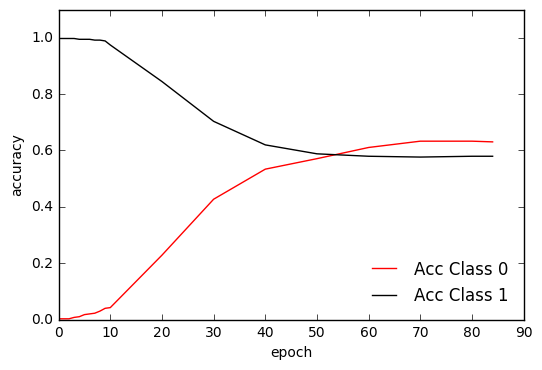

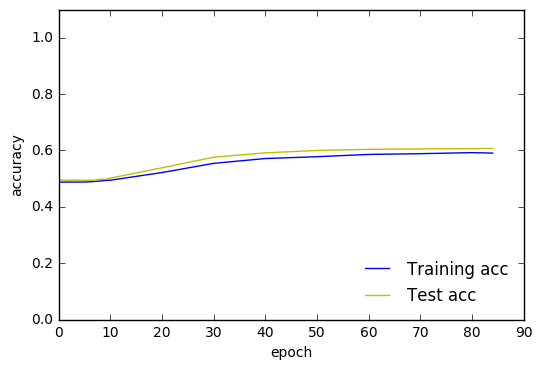

In [8]:
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
    
best_lambda_L2 = 0.0055
train_neural_network_CV(x, best_lambda_L2)



# The following cells are only here for parameter tuning and tests

In [12]:
# Def for hyperparameters grid-search

def train_neural_network_CV_grid_search(x, lambda_):

    hidden_1_layer = {
        'weights': tf.Variable(tf.truncated_normal([feature_count, n_nodes_hl1], stddev=0.1, seed=seed), name="h1_weights"),
        # 'weights': tf.Variable(tf.zeros([feature_count, n_nodes_hl1]), name="h1_weights"),
        'biases': tf.Variable(tf.constant(1.0, shape=[n_nodes_hl1]), name="h1_biases")
    }
    hidden_2_layer = {
        'weights': tf.Variable(tf.truncated_normal([n_nodes_hl1, n_nodes_hl2], stddev=0.1, seed=seed), name="h2_weights"),
        'biases': tf.Variable(tf.constant(1.0, shape=[n_nodes_hl2]), name="h2_biases")
    }

    hidden_3_layer = {
        'weights': tf.Variable(tf.truncated_normal([n_nodes_hl2, n_nodes_hl3], stddev=0.1, seed=seed), name="h3_weights"),
        'biases': tf.Variable(tf.constant(1.0, shape=[n_nodes_hl3]), name="h3_biases")
    }
    output_layer = {
        'weights': tf.Variable(tf.truncated_normal([n_nodes_hl1, n_classes], stddev=0.1, seed=seed), name="o_weights"),
        # 'weights': tf.Variable(tf.zeros([n_nodes_hl1, n_classes]), name="o_weights"),
        'biases': tf.Variable(tf.constant(1.0, shape=[n_classes]), name="o_biases")
    }

    l1 = tf.add(tf.matmul(x, hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.relu6(l1)

    l1_drop = tf.nn.dropout(l1, dropout_prob, seed=seed)


    l2 = tf.add(tf.matmul(l1_drop, hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu6(l2)

    l2_drop = tf.nn.dropout(l2, dropout_prob, seed=seed)

    l3 = tf.add(tf.matmul(l2, hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3 = tf.nn.sigmoid(l3)

    l3_drop = tf.nn.dropout(l3, dropout_prob, seed=seed)

    to_save = [hidden_1_layer['weights'], hidden_1_layer['biases'], output_layer['weights'], output_layer['biases']]

    prediction = tf.matmul(l1_drop, output_layer['weights']) +  output_layer['biases']

    regularizers = (tf.nn.l2_loss(hidden_1_layer['weights']) + tf.nn.l2_loss(hidden_1_layer['biases']) +
                                tf.nn.l2_loss(output_layer['weights']) + tf.nn.l2_loss(output_layer['biases']))

    #stats 
    vals = []
    trains = []
    tests = []
    x_range = []
    f1_vals = []
    acc_1s = []
    acc_0s = []

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(prediction, y))

    #Eval this to get probability of [winning,losing]
    prob = tf.nn.softmax(prediction, name="prob")

    #learning rate can be passed
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost + lambda_ * regularizers)

    #metrics
    correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
    false_prediction = tf.logical_not(correct_prediction)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

    #use for f1 score if needed
    true_positives = tf.reduce_sum(tf.to_int32(tf.logical_and(correct_prediction, tf.equal(tf.argmax(tf.nn.softmax(y),1), True) )))
    false_positives = tf.reduce_sum(tf.to_int32(tf.logical_and(false_prediction, tf.equal(tf.argmax(tf.nn.softmax(y),1), True) )))
    true_negatives = tf.reduce_sum(tf.to_int32(tf.logical_and(correct_prediction, tf.equal(tf.argmax(tf.nn.softmax(y),1), False) )))
    false_negatives = tf.reduce_sum(tf.to_int32(tf.logical_and(false_prediction, tf.equal(tf.argmax(tf.nn.softmax(y),1), False) )))

    #acc for each class
    class_0 = tf.where(tf.equal(tf.argmax(y, 1), 0))
    class_0 = tf.reshape(class_0, [tf.shape(class_0)[0]])
    pred_0 = tf.gather(prediction, class_0)
    y_0 = tf.gather(y, class_0)
    class_0_correct = tf.equal(tf.argmax(pred_0,1), tf.argmax(y_0,1))
    acc_0 = tf.reduce_mean(tf.cast(class_0_correct, 'float'))

    class_1 = tf.where(tf.equal(tf.argmax(y, 1), 1))
    class_1 = tf.reshape(class_1, [tf.shape(class_1)[0]])
    pred_1 = tf.gather(prediction, class_1)
    y_1 = tf.gather(y, class_1)
    class_1_correct = tf.equal(tf.argmax(pred_1,1), tf.argmax(y_1,1))
    acc_1 = tf.reduce_mean(tf.cast(class_1_correct, 'float'))

    display_step = 1

    saver = tf.train.Saver(to_save)

    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        #tf.global_variables_initializer
        for epoch in range(hm_epochs):
            fold_index = 0

            kf = KFold(n_splits=5, random_state=seed, shuffle=True)
            for train_index, test_index in kf.split(train_features, train_labels):
                fold_index += 1
                X_train, X_test = train_features[train_index], train_features[test_index]
                y_train, y_test = train_labels[train_index], train_labels[test_index]

                _, c = sess.run([optimizer, cost], feed_dict = {x: X_train, y: y_train, dropout_prob: 0.5})

                train_accuracy = accuracy.eval(feed_dict={ x: X_train, y: y_train, dropout_prob: 1})
                test_accuracy = accuracy.eval(feed_dict={ x: X_test, y: y_test, dropout_prob: 1})
                
  
        validation_accuracy = accuracy.eval(feed_dict={ x: validation_features, y: validation_labels, dropout_prob: 1})
        print ('val:%.10f' % (validation_accuracy))

In [13]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [47]:
#Lambda grid search

lambdas = np.logspace(-7, 0, 35)

for i in lambdas:
    print('Lambda = ', i)
    train_neural_network_CV_grid_search(x, i)
    print('_________')


Lambda =  1e-07
val:0.5826666951
_________
Lambda =  1.60650600385e-07
val:0.5826666951
_________
Lambda =  2.58086154042e-07
val:0.5826666951
_________
Lambda =  4.1461695598e-07
val:0.5826666951
_________
Lambda =  6.66084629081e-07
val:0.5826666951
_________
Lambda =  1.07006895569e-06
val:0.5826666951
_________
Lambda =  1.71907220186e-06
val:0.5826666951
_________
Lambda =  2.76169981334e-06
val:0.5826666951
_________
Lambda =  4.43668733098e-06
val:0.5826666951
_________
Lambda =  7.12756483444e-06
val:0.5826666951
_________
Lambda =  1.14504756994e-05
val:0.5826666951
_________
Lambda =  1.8395257958e-05
val:0.5826666951
_________
Lambda =  2.9552092352e-05
val:0.5826666951
_________
Lambda =  4.747561379e-05
val:0.5826666951
_________
Lambda =  7.62698585902e-05
val:0.5826666951
_________
Lambda =  0.000122527985738
val:0.5826666951
_________
Lambda =  0.000196841944729
val:0.5826666951
_________
Lambda =  0.000316227766017
val:0.5839999914
_________
Lambda =  0.000508021804691

In [15]:
#Lambda grid search

neurons = np.arange(5, 170, 5)
#feed forward neural net
hm_epochs = 100
best_lambda_L2 = 0.0055


for n_neur in neurons:
    print('#Neurons = ', n_neur)
    n_nodes_hl1 = n_neur
    
    train_neural_network_CV_grid_search(x, best_lambda_L2)
    print('_________')

#Neurons =  5
val:0.4959999919
_________
#Neurons =  10
val:0.5346666574
_________
#Neurons =  15
val:0.5440000296
_________
#Neurons =  20
val:0.5960000157
_________
#Neurons =  25
val:0.5906666517
_________
#Neurons =  30
val:0.5733333230
_________
#Neurons =  35
val:0.5879999995
_________
#Neurons =  40
val:0.6000000238
_________
#Neurons =  45
val:0.5786666870
_________
#Neurons =  50
val:0.5626666546
_________
#Neurons =  55
val:0.5866666436
_________
#Neurons =  60
val:0.5746666789
_________
#Neurons =  65
val:0.5933333039
_________
#Neurons =  70
val:0.5720000267
_________
#Neurons =  75
val:0.5960000157
_________
#Neurons =  80
val:0.5933333039
_________
#Neurons =  85
val:0.5839999914
_________
#Neurons =  90
val:0.5866666436
_________
#Neurons =  95
val:0.5920000076
_________
#Neurons =  100
val:0.6000000238
_________
#Neurons =  105
val:0.5933333039
_________
#Neurons =  110
val:0.6093333364
_________
#Neurons =  115
val:0.5879999995
_________
#Neurons =  120
val:0.589333355